In [ ]:
!pip install rdkit

In [ ]:
!pip install bunch

In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from copy import copy

import matplotlib.pyplot as plt
%matplotlib inline

import json
from bunch import Bunch
import time
import os
import glob
from tensorflow.keras.utils import Sequence
from tensorflow.keras import Sequential
from tensorflow.keras.models import model_from_json
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.initializers import RandomNormal
from glob import glob
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

from rdkit import Chem, RDLogger
RDLogger.DisableLog('rdApp.*')

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 10837673750858936153
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14626652160
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 8918792215293784948
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [ ]:
class SmilesTokenizer(object):
    def __init__(self, config):
        self.config = config
        if(self.config.finetuning_enable):
          atoms = [
              'B', 'Br', 'I', 'P', 'Se',
              'N', 'Cl', 'F', 'H', 'C', 'O', 'S'
          ]
          special = [
              'c', '(', ')', '1', '2','=', '[', ']', '@', 'n', '\n', '3',
              '+', '-', 's', 'o', '4', '/', '#', '\\', '5', '6', '7', '8'
          ]
        else:
          atoms = [
             'Br',
             'N', 'Cl', 'F', 'H', 'C', 'O', 'S'
          ]
          special = [
              '=', '(', ')','1', '@', '2', '[', ']', '3', '/', '#', '\\', '+', '4', '-'
          ]
        padding = ['G', 'A', 'E']

        self.table = sorted(atoms, key=len, reverse=True) + special + padding
        table_len = len(self.table)

        self.table_2_chars = list(filter(lambda x: len(x) == 2, self.table))
        self.table_1_chars = list(filter(lambda x: len(x) == 1, self.table))

        self.one_hot_dict = {}
        for i, symbol in enumerate(self.table):
            vec = np.zeros(table_len, dtype=np.float32)
            vec[i] = 1
            self.one_hot_dict[symbol] = vec

    def tokenize(self, smiles):
        smiles = smiles + ' '
        N = len(smiles)
        token = []
        i = 0
        while (i < N):
            c1 = smiles[i]
            c2 = smiles[i:i + 2]

            if c2 in self.table_2_chars:
                token.append(c2)
                i += 2
                continue

            if c1 in self.table_1_chars:
                token.append(c1)
                i += 1
                continue

            i += 1

        return token

    def one_hot_encode(self, tokenized_smiles):
        result = np.array(
            [self.one_hot_dict[symbol] for symbol in tokenized_smiles],
            dtype=np.float32)
        result = result.reshape(1, result.shape[0], result.shape[1])
        return result

In [ ]:
class DataLoader(Sequence):
    def __init__(self, config, data_type='train'):
        self.config = config
        self.data_type = data_type
        assert self.data_type in ['train', 'valid', 'finetune']

        self.max_len = 0

        if self.data_type == 'train':
            self.smiles = self._load(self.config.data_filename)
        elif self.data_type == 'finetune':
            self.smiles = self._load(self.config.finetune_data_filename)
        else:
            pass

        self.st = SmilesTokenizer(self.config)
        self.one_hot_dict = self.st.one_hot_dict

        self.tokenized_smiles = self._tokenize(self.smiles)

        if self.data_type in ['train', 'valid']:
            self.idx = np.arange(len(self.tokenized_smiles))
            self.valid_size = int(
                np.ceil(
                    len(self.tokenized_smiles) * self.config.validation_split))
            np.random.seed(self.config.seed)
            np.random.shuffle(self.idx)

    def _set_data(self):
        if self.data_type == 'train':
            ret = [
                self.tokenized_smiles[self.idx[i]]
                for i in self.idx[self.valid_size:]
            ]
        elif self.data_type == 'valid':
            ret = [
                self.tokenized_smiles[self.idx[i]]
                for i in self.idx[:self.valid_size]
            ]
        else:
            ret = self.tokenized_smiles
        return ret

    def _load(self, data_filename):
        length = self.config.data_length
        print('loading SMILES...')
        with open(data_filename) as f:
            smiles = [s.rstrip() for s in f]
        if length != 0:
            smiles = smiles[:length]
        print('done.')
        return smiles

    def _tokenize(self, smiles):
        assert isinstance(smiles, list)
        print('tokenizing SMILES...')
        tokenized_smiles = [self.st.tokenize(smi) for smi in tqdm(smiles)]

        if self.data_type == 'train':
            for tokenized_smi in tokenized_smiles:
                length = len(tokenized_smi)
                if self.max_len < length:
                    self.max_len = length
            self.config.train_smi_max_len = self.max_len
        print('done.')
        return tokenized_smiles

    def __len__(self):
        target_tokenized_smiles = self._set_data()
        if self.data_type in ['train', 'valid']:
            ret = int(
                np.ceil(
                    len(target_tokenized_smiles) /
                    float(self.config.batch_size)))
        else:
            ret = int(
                np.ceil(
                    len(target_tokenized_smiles) /
                    float(self.config.finetune_batch_size)))
        return ret

    def __getitem__(self, idx):
        target_tokenized_smiles = self._set_data()
        if self.data_type in ['train', 'valid']:
            data = target_tokenized_smiles[idx *
                                           self.config.batch_size:(idx + 1) *
                                           self.config.batch_size]
        else:
            data = target_tokenized_smiles[idx *
                                           self.config.finetune_batch_size:
                                           (idx + 1) *
                                           self.config.finetune_batch_size]
        data = self._padding(data)

        self.X, self.y = [], []
        for tp_smi in data:
            X = [self.one_hot_dict[symbol] for symbol in tp_smi[:-1]]
            self.X.append(X)
            y = [self.one_hot_dict[symbol] for symbol in tp_smi[1:]]
            self.y.append(y)

        self.X = np.array(self.X, dtype=np.float32)
        self.y = np.array(self.y, dtype=np.float32)

#        return self.X, self.y, [None]
        return self.X, self.y

    def _pad(self, tokenized_smi):
        return ['G'] + tokenized_smi + ['E'] + [
            'A' for _ in range(self.max_len - len(tokenized_smi))
        ]

    def _padding(self, data):
        padded_smiles = [self._pad(t_smi) for t_smi in data]
        return padded_smiles

In [ ]:
class Generator(object):
    def __init__(self, modeler):
        self.session = modeler.session
        self.model = modeler.model
        self.config = modeler.config
        self.st = SmilesTokenizer(self.config)

    def _generate(self, sequence):
        while (sequence[-1] != 'E') and (len(self.st.tokenize(sequence)) <=
                                         self.config.smiles_max_length):
            x = self.st.one_hot_encode(self.st.tokenize(sequence))
            preds = self.model.predict_on_batch(x)[0][-1]
            next_idx = self.sample_with_temp(preds)
            sequence += self.st.table[next_idx]

        sequence = sequence[1:].rstrip('E')
        return sequence

    def sample_with_temp(self, preds):
        streched = np.log(preds) / self.config.sampling_temp
        streched_probs = np.exp(streched) / np.sum(np.exp(streched))
        return np.random.choice(range(len(streched)), p=streched_probs)

    def sample(self, num=1, start='G'):
        sampled = []
        if self.session == 'generate':
            for _ in tqdm(range(num)):
                sampled.append(self._generate(start))
            return sampled
        else:
            # from rdkit import Chem, RDLogger
            # RDLogger.DisableLog('rdApp.*')
            while len(sampled) < num:
                sequence = self._generate(start)
                mol = Chem.MolFromSmiles(sequence)
                if mol is not None:
                    canon_smiles = Chem.MolToSmiles(mol)
                    sampled.append(canon_smiles)
            return sampled

In [ ]:
class Model(object):
    def __init__(self, config, session='train'):
        assert session in ['train', 'generate', 'finetune'], \
                'one of {train, generate, finetune}'

        self.config = config
        self.session = session
        self.model = None

        if self.session == 'train':
            self.build_model()
        else:
            self.model = self.load(self.config.model_arch_filename,
                                   self.config.model_weight_filename)

    def build_model(self):
        st = SmilesTokenizer(self.config)
        n_table = len(st.table)
        weight_init = RandomNormal(mean=0.0,
                                   stddev=0.05,
                                   seed=self.config.seed)

        self.model = Sequential()
        self.model.add(
            LSTM(units=self.config.units,
                 input_shape=(None, n_table),
                 return_sequences=True,
                 kernel_initializer=weight_init,
                 dropout=0.3))
        self.model.add(
            LSTM(units=self.config.units,
                 input_shape=(None, n_table),
                 return_sequences=True,
                 kernel_initializer=weight_init,
                 dropout=0.5))
        self.model.add(
            Dense(units=n_table,
                  activation='softmax',
                  kernel_initializer=weight_init))

        arch = self.model.to_json(indent=2)
        self.config.model_arch_filename = 'model_arch.json'
        with open(self.config.model_arch_filename, 'w') as f:
            f.write(arch)

        self.model.compile(optimizer=self.config.optimizer,
                           loss='categorical_crossentropy')

    def save(self, checkpoint_path):
        assert self.model, 'You have to build the model first.'

        print('Saving model ...')
        self.model.save_weights(checkpoint_path)
        print('model saved.')

    def load(self, model_arch_file, checkpoint_file):
        print(f'Loading model architecture from {model_arch_file} ...')
        with open(model_arch_file) as f:
            model = model_from_json(f.read())
        print(f'Loading model checkpoint from {checkpoint_file} ...')
        model.load_weights(checkpoint_file)
        print('Loaded the Model.')
        return model

In [ ]:
class Trainer(object):
    def __init__(self, modeler, train_data_loader, valid_data_loader):
        self.model = modeler.model
        self.config = modeler.config
        self.train_data_loader = train_data_loader
        self.valid_data_loader = valid_data_loader
        self.callbacks = []
        self.init_callbacks()

    def init_callbacks(self):
        self.callbacks.append(
            ModelCheckpoint(
                filepath= os.path.join(
                    self.config.checkpoint_dir,
                    '%s-{epoch:02d}-{val_loss:.2f}.hdf5' %
                    self.config.exp_name),
                monitor=self.config.checkpoint_monitor,
                mode=self.config.checkpoint_mode,
                save_best_only=self.config.checkpoint_save_best_only,
                save_weights_only=self.config.checkpoint_save_weights_only,
                verbose=self.config.checkpoint_verbose,
            ))
        self.callbacks.append(
            TensorBoard(
                log_dir=self.config.tensorboard_log_dir,
                write_graph=self.config.tensorboard_write_graph,
            ))

    def train(self):
#        history = self.model.fit_generator(
        history = self.model.fit(
            self.train_data_loader,
            steps_per_epoch=self.train_data_loader.__len__(),
            epochs=self.config.num_epochs,
            verbose=self.config.verbose_training,
            validation_data=self.valid_data_loader,
            validation_steps=self.valid_data_loader.__len__(),
            use_multiprocessing=True,
            shuffle=True,
            callbacks=self.callbacks)

        last_weight_file = glob(
            os.path.join(
                f'{self.config.checkpoint_dir}',
                f'{self.config.exp_name}-{self.config.num_epochs:02}*.hdf5')
        )[0]

        assert os.path.exists(last_weight_file)
        self.config.model_weight_filename = last_weight_file

        with open('config.json', 'w') as f:
            f.write(self.config.toJSON(indent=2))
        return history

In [ ]:
class Finetuner(Generator):
    def __init__(self, modeler, finetune_data_loader):
        self.session = modeler.session
        self.model = modeler.model
        self.config = modeler.config
        self.finetune_data_loader = finetune_data_loader
        self.st = SmilesTokenizer(self.config)

    def finetune(self):
        self.model.compile(optimizer=self.config.optimizer,
                           loss='categorical_crossentropy')

#        history = self.model.fit_generator(
        history = self.model.fit(
            self.finetune_data_loader,
            steps_per_epoch=self.finetune_data_loader.__len__(),
            epochs=self.config.finetune_epochs,
            verbose=self.config.verbose_training,
            use_multiprocessing=True,
            shuffle=True)
        return history

In [ ]:
def get_config_from_json(json_file):
    with open(json_file, 'r') as config_file:
        config_dict = json.load(config_file)
    config = Bunch(config_dict)
    return config


def process_config(json_file):
    config = get_config_from_json(json_file)
    config.config_file = json_file
    # config.exp_dir = os.path.join(
    #     'experiments', time.strftime('%Y-%m-%d/', time.localtime()),
    #     config.exp_name)
    config.tensorboard_log_dir = 'logs/'
    config.checkpoint_dir = 'checkpoints/'
    return config

In [ ]:
CONFIG_FILE_1 = 'base_config_1.json'
config1 = process_config(CONFIG_FILE_1)

In [ ]:
print('Create the data generator.')
train_dl_1 = DataLoader(config1, data_type='train')
valid_dl_1 = copy(train_dl_1)
valid_dl_1.data_type = 'valid'

print('Create the model.')
modeler_1 = Model(config1, session='train')

print('Create the trainer')
trainer_1 = Trainer(modeler_1, train_dl_1, valid_dl_1)

print('Start training the model.')
history_1 = trainer_1.train()

Create the data generator.
loading SMILES...
done.
tokenizing SMILES...


100%|██████████| 61565/61565 [00:01<00:00, 43779.79it/s]


done.
Create the model.
Create the trainer
Start training the model.
Epoch 1/40


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


193/193 [==============================] - ETA: 0s - loss: 1.4121
Epoch 1: saving model to checkpoints/LSTM_Model_1-01-1.00.hdf5
193/193 [==============================] - 47s 206ms/step - loss: 1.4121 - val_loss: 1.0029
Epoch 2/40
193/193 [==============================] - ETA: 0s - loss: 0.9435
Epoch 2: saving model to checkpoints/LSTM_Model_1-02-0.74.hdf5
193/193 [==============================] - 42s 215ms/step - loss: 0.9435 - val_loss: 0.7359
Epoch 3/40
193/193 [==============================] - ETA: 0s - loss: 0.8314
Epoch 3: saving model to checkpoints/LSTM_Model_1-03-0.65.hdf5
193/193 [==============================] - 37s 193ms/step - loss: 0.8314 - val_loss: 0.6474
Epoch 4/40
193/193 [==============================] - ETA: 0s - loss: 0.7726
Epoch 4: saving model to checkpoints/LSTM_Model_1-04-0.59.hdf5
193/193 [==============================] - 38s 197ms/step - loss: 0.7726 - val_loss: 0.5887
Epoch 5/40
193/193 [==============================] - ETA: 0s - loss: 0.7339
Epoch 

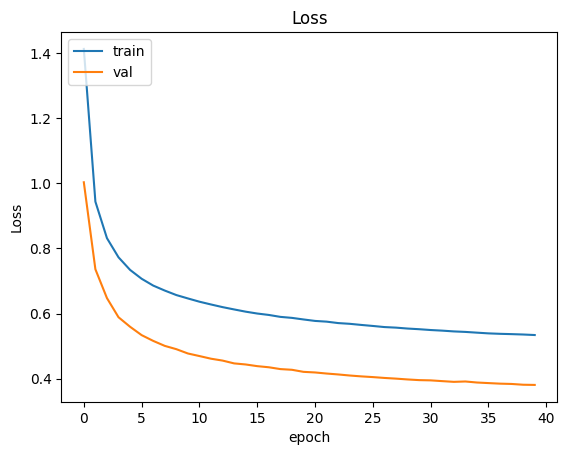

In [ ]:
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
CONFIG_FILE_GENERATION = 'config.json'
config_gen = process_config(CONFIG_FILE_GENERATION)

In [ ]:
modeler_generation_1 = Model(config_gen, session='generate')

Loading model architecture from model_arch.json ...
Loading model checkpoint from checkpoints/LSTM_Model_1-40-0.38.hdf5 ...
Loaded the Model.


In [ ]:
generator_1 = Generator(modeler_generation_1)
sampled_smiles_1 = generator_1.sample(num=1000)

100%|██████████| 1000/1000 [05:07<00:00,  3.25it/s]


In [ ]:
with open('sampled_smiles_model_1.smi', 'w') as f:
  for smi in sampled_smiles_1:
    f.write(smi + '\n')

In [ ]:
valid_mols = []
for smi in sampled_smiles_1:
    mol = Chem.MolFromSmiles(smi)
    if mol is not None:
        valid_mols.append(mol)
# low validity
print(f'{len(valid_mols) / 1000:.2%}')

79.00%


In [ ]:
valid_smiles = [Chem.MolToSmiles(mol) for mol in valid_mols]
# high uniqueness
print(f'{len(set(valid_smiles)) / len(valid_smiles):.2%}')

99.87%


###Обучение с последующим finetuning

In [ ]:
CONFIG_FILE_2 = 'base_config_2.json'
config2 = process_config(CONFIG_FILE_2)

In [ ]:
print('Create the data generator.')
train_dl_2 = DataLoader(config2, data_type='train')
valid_dl_2 = copy(train_dl_2)
valid_dl_2.data_type = 'valid'

print('Create the model.')
modeler_2 = Model(config2, session='train')

print('Create the trainer')
trainer_2 = Trainer(modeler_2, train_dl_2, valid_dl_2)

print('Start training the model.')
history_2 = trainer_2.train()

Create the data generator.
loading SMILES...
done.
tokenizing SMILES...


100%|██████████| 249455/249455 [00:08<00:00, 30602.28it/s]


done.
Create the model.
Create the trainer
Start training the model.
Epoch 1/20


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


186/780 [======>.......................] - ETA: 3:35 - loss: 1.1857

Process Keras_worker_ForkPoolWorker-1:
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/pool.py", line 131, in worker
    put((job, i, result))
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 377, in put
    self._writer.send_bytes(obj)
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 405, in _send_bytes
    self._send(buf)
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
KeyboardInterrupt
Exception in thread Thread-15 (_handle_results):
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, i

In [ ]:
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
CONFIG_FILE_FINETUNE = 'config.json'

In [ ]:
config_ft = process_config(CONFIG_FILE_FINETUNE)

modeler_finetuning = Model(config_ft, session='finetune')
finetune_dl = DataLoader(config_ft, data_type='finetune')

finetuner = Finetuner(modeler_finetuning, finetune_dl)
history = finetuner.finetune()

Loading model architecture from model_arch.json ...
Loading model checkpoint from checkpoints/LSTM_Model_2-14-0.27.hdf5 ...
Loaded the Model.
loading SMILES...
done.
tokenizing SMILES...


100%|██████████| 5000/5000 [00:00<00:00, 13541.68it/s]


done.
Epoch 1/20


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


5000/5000 [==============================] - 54s 9ms/step - loss: 1.1122


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 2/20
5000/5000 [==============================] - 49s 10ms/step - loss: 1.0073
Epoch 3/20
5000/5000 [==============================] - 52s 10ms/step - loss: 0.9677
Epoch 4/20
5000/5000 [==============================] - 48s 10ms/step - loss: 0.9402
Epoch 5/20
5000/5000 [==============================] - 48s 10ms/step - loss: 0.9202
Epoch 6/20
5000/5000 [==============================] - 57s 11ms/step - loss: 0.9044
Epoch 7/20
5000/5000 [==============================] - 59s 12ms/step - loss: 0.8917
Epoch 8/20
5000/5000 [==============================] - 54s 11ms/step - loss: 0.8795
Epoch 9/20
5000/5000 [==============================] - 49s 10ms/step - loss: 0.8702
Epoch 10/20
5000/5000 [==============================] - 51s 10ms/step - loss: 0.8607
Epoch 11/20
5000/5000 [==============================] - 48s 10ms/step - loss: 0.8550
Epoch 12/20
5000/5000 [==============================] - 48s 9ms/step - loss: 0.8423
Epoch 13/20
5000/5000 [==============================] - 48s 10

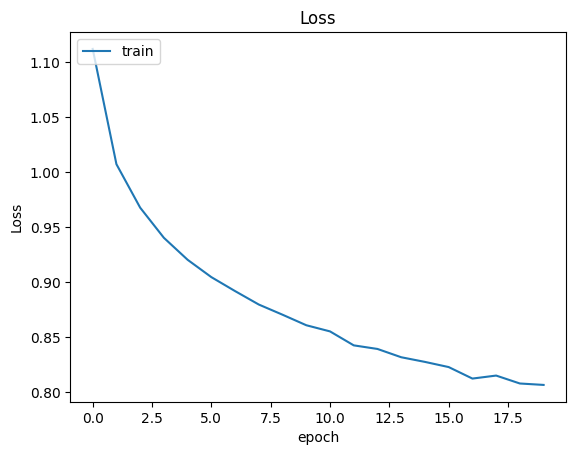

In [ ]:
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
finetuned_smiles = finetuner.sample(num=1000)

In [ ]:
with open('finetuned_smiles.smi', 'w') as f:
  for smi in finetuned_smiles:
    f.write(smi + '\n')

In [ ]:
valid_mols = []
for smi in finetuned_smiles:
    mol = Chem.MolFromSmiles(smi)
    if mol is not None:
        valid_mols.append(mol)
# low validity
print(f'{len(valid_mols) / 1000:.2%}')

100.00%


###Без предварительного обучения

In [ ]:
config3 = process_config('base_config_3.json')

In [ ]:
print('Create the data generator.')
train_dl_3 = DataLoader(config3, data_type='train')
valid_dl_3 = copy(train_dl_3)
valid_dl_3.data_type = 'valid'

print('Create the model.')
modeler_3 = Model(config3, session='train')

print('Create the trainer')
trainer_3 = Trainer(modeler_3, train_dl_3, valid_dl_3)

print('Start training the model.')
history_3 = trainer_3.train()

Create the data generator.
loading SMILES...
done.
tokenizing SMILES...


100%|██████████| 5000/5000 [00:00<00:00, 23120.71it/s]


done.
Create the model.
Create the trainer
Start training the model.
Epoch 1/100


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


16/16 [==============================] - ETA: 0s - loss: 2.3760
Epoch 1: saving model to checkpoints/LSTM_Model_3-01-1.89.hdf5
16/16 [==============================] - 13s 566ms/step - loss: 2.3760 - val_loss: 1.8856
Epoch 2/100
15/16 [===========================>..] - ETA: 0s - loss: 1.8139
Epoch 2: saving model to checkpoints/LSTM_Model_3-02-1.70.hdf5
16/16 [==============================] - 7s 416ms/step - loss: 1.8127 - val_loss: 1.6989
Epoch 3/100
16/16 [==============================] - ETA: 0s - loss: 1.6918
Epoch 3: saving model to checkpoints/LSTM_Model_3-03-1.63.hdf5
16/16 [==============================] - 7s 447ms/step - loss: 1.6918 - val_loss: 1.6341
Epoch 4/100
16/16 [==============================] - ETA: 0s - loss: 1.6404
Epoch 4: saving model to checkpoints/LSTM_Model_3-04-1.60.hdf5
16/16 [==============================] - 7s 436ms/step - loss: 1.6404 - val_loss: 1.5985
Epoch 5/100
15/16 [===========================>..] - ETA: 0s - loss: 1.6052
Epoch 5: saving model t

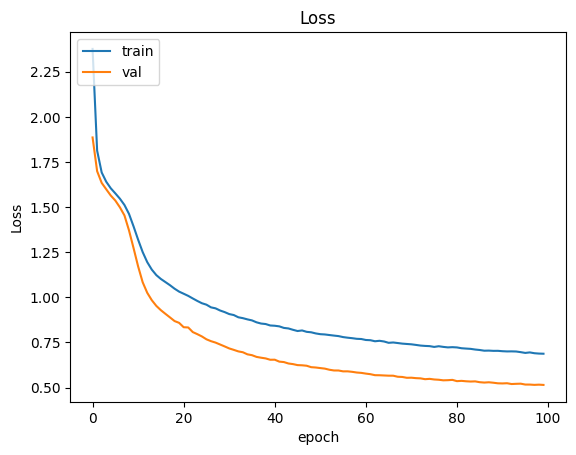

In [ ]:
plt.plot(history_3.history['loss'])
plt.plot(history_3.history['val_loss'])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
CONFIG_FILE_GENERATION = 'config.json'
config_gen = process_config(CONFIG_FILE_GENERATION)

In [ ]:
modeler_generation_3 = Model(config_gen, session='generate')
generator_3 = Generator(modeler_generation_3)
sampled_smiles_3 = generator_3.sample(num=1000)

Loading model architecture from model_arch.json ...
Loading model checkpoint from checkpoints/LSTM_Model_3-100-0.52.hdf5 ...
Loaded the Model.


100%|██████████| 1000/1000 [05:48<00:00,  2.87it/s]


In [ ]:
with open('sampled_smiles_model_3.smi', 'w') as f:
  for smi in sampled_smiles_3:
    f.write(smi + '\n')

In [ ]:
valid_mols = []
for smi in sampled_smiles_3:
    mol = Chem.MolFromSmiles(smi)
    if mol is not None:
        valid_mols.append(mol)
# low validity
print(f'{len(valid_mols) / 1000:.2%}')

24.00%
